In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import os
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse

In [ ]:
! gdown 1qEg5edcGW0QziI60OABaxY8IzGyDSZpV
! unzip news_headline_clustering.zip

Downloading...
From (original): https://drive.google.com/uc?id=1qEg5edcGW0QziI60OABaxY8IzGyDSZpV
From (redirected): https://drive.google.com/uc?id=1qEg5edcGW0QziI60OABaxY8IzGyDSZpV&confirm=t&uuid=e064b175-aece-41c6-9a04-45b09870a550
To: /content/news_headline_clustering.zip
100% 31.0M/31.0M [00:00<00:00, 143MB/s] 
Archive:  news_headline_clustering.zip
replace news_bad.par? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: news_bad.par            
replace news_curated.par? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: news_curated.par        
replace news_good.par? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: news_good.par           


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dfcurated = pd.read_parquet('news_curated.par')[['title']]
dfgood = pd.read_parquet('news_good.par')[['title']]
dfbad = pd.read_parquet('news_bad.par')[['title']]

In [ ]:
#sentiment proved to be unuseful most are neutral
'''
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load the model and tokenizer
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a pipeline for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Assuming dfcurated has a column 'title' containing the news headlines
# Apply the sentiment analysis to each title
def get_sentiment(text):
    result = sentiment_pipeline(text)[0]
    return result['label']

# Apply to the DataFrame and store the results
dfcurated['sentiment'] = dfcurated['title'].apply(get_sentiment)

dfcurated.head()
'''

'\nfrom transformers import AutoTokenizer, AutoModelForSequenceClassification\nfrom transformers import pipeline\n\n# Load the model and tokenizer\nmodel_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"\ntokenizer = AutoTokenizer.from_pretrained(model_name)\nmodel = AutoModelForSequenceClassification.from_pretrained(model_name)\n\n# Create a pipeline for sentiment analysis\nsentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)\n\n# Assuming dfcurated has a column \'title\' containing the news headlines\n# Apply the sentiment analysis to each title\ndef get_sentiment(text):\n    result = sentiment_pipeline(text)[0]\n    return result[\'label\']\n\n# Apply to the DataFrame and store the results\ndfcurated[\'sentiment\'] = dfcurated[\'title\'].apply(get_sentiment)\n\ndfcurated.head()\n'

We used a classifier model to help identify which clusters containted which information. Though the categories are limited within the financial domain.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load the model and tokenizer
model_name = "ilsilfverskiold/classify-news-category-iptc"
#"ilsilfverskiold/classify-news-category-iptc"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create the pipeline
category_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, truncation=True)

# Apply the classification to each title
def get_category(text):
    result = category_pipeline(text)[0]
    return result['label']

# Add to the DataFrame
dfcurated['news_category'] = dfcurated['title'].apply(get_category)
dfcurated.head()

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,title,news_category
0,Smes and Employment Focus Wave of Claims to BB...,"crime, law and justice"
1,Selby Power Limited: notice of application for...,science and technology
2,"Jetstar, AirAsia, Singapore Airlines Flights H...","disaster, accident, and emergency incident"
3,Economics.- TK Elevator claims elevator and ac...,environment
4,Fitch Affirms Barclays Dryrock Issuance Trust,"economy, business, and finance"


In [ ]:
dfcurated['news_category'].value_counts()

,count
news_category,
"economy, business, and finance",1554
science and technology,487
politics,380
sport,138
"disaster, accident, and emergency incident",132
"conflict, war and peace",124
"arts, culture, entertainment and media",100
environment,77
human interest,74


# 1. Embed the Titles using:

## (a) sentence transformer trained on the financial domain

In [ ]:
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# 1. (Optional) Your existing preprocessor
lemmatizer   = WordNetLemmatizer()
stop_words   = set(stopwords.words('english'))

def preprocess(text):
    tokens = text.split()
    clean  = [lemmatizer.lemmatize(t) for t in tokens if t.lower() not in stop_words]
    return " ".join(clean)

# apply to your DataFrame
texts_cleanC = dfcurated['title'].map(preprocess).tolist()

# 2. Load a pretrained SentenceTransformer
model = SentenceTransformer('FinLang/finance-embeddings-investopedia')
 #("Salesforce/SFR-Embedding-2_R")
 #('FinLang/finance-embeddings-investopedia')
#    └─ you can swap in any SBERT model you like

# 3. Encode all titles into a NumPy array of shape (n_samples, embedding_dim)
embeddingsC = model.encode(
    texts_cleanC,
    show_progress_bar=True,
    convert_to_numpy=True
)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Batches:   0%|          | 0/101 [00:00<?, ?it/s]

## (b) Attempt reducing the dimensionality with the SVD method (keep at least 80-90 variance of the original data)

In [ ]:

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.pipeline import make_pipeline

# Perform SVD and normalization
scaler = StandardScaler(with_mean=False)
#n components originally 200
svd = TruncatedSVD(n_components=200, random_state=42)  # Tune n_components as needed
normalizer = Normalizer(copy=False)

# Create pipeline
lsa = make_pipeline(svd,normalizer)

# Apply the pipeline to the TF-IDF matrix
X_reduced = lsa.fit_transform(embeddingsC)#X_tfidf)

# Check explained variance
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance: {explained_variance:.2f}")

Explained variance: 0.91


#Elbow Method for K Means

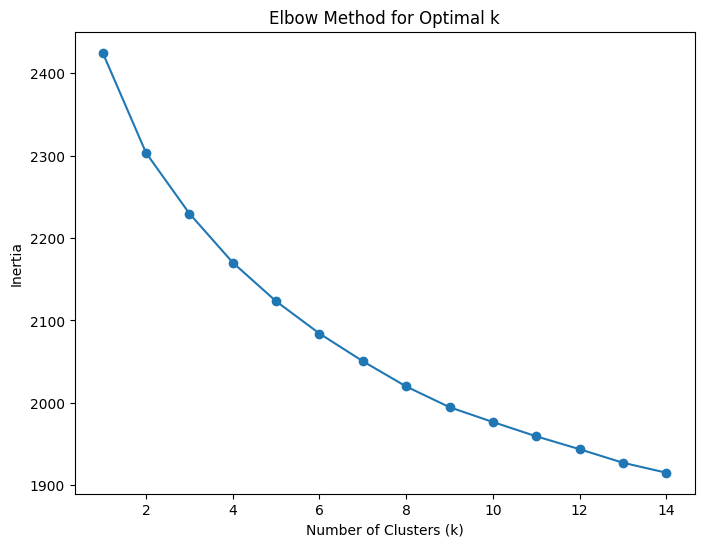

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_reduced)  # Use scaled feature matrix
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

#based on our defaults 7 seems to be a good cluster amount

Elbow method was hard to determine, so we used sihouette score to assist. 2 seemed too few so we settled with 8, however, all the scores were rather low seemingly signaling to noisy data.

0.06522466
0.051390875
0.035017524
0.03751171
0.03462653
0.040224265
0.044464197
0.03875695
0.042609964
0.044783756


Text(0, 0.5, 'Silhouette Score')

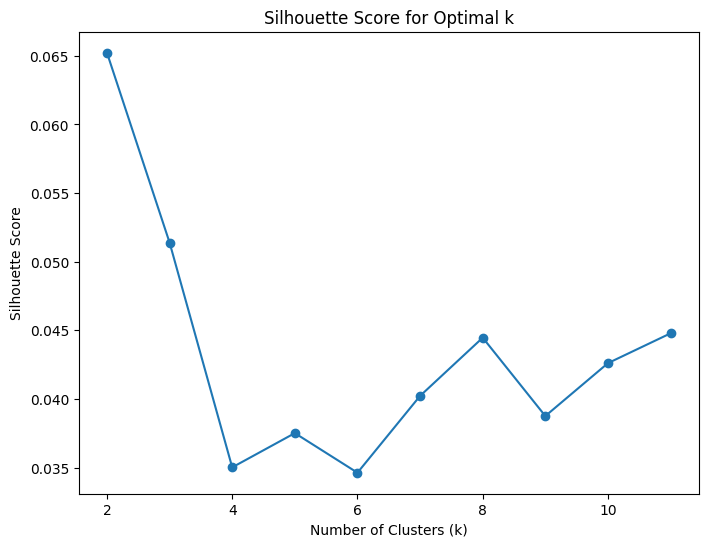

In [ ]:
#graph silohuette score
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 12)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_reduced)  # Use scaled feature
    silhouette_scores.append(silhouette_score(X_reduced, kmeans.labels_))
    print(silhouette_score(X_reduced, kmeans.labels_))
    #print(silhouette_score(X_sentiment, kmeans.labels_))

plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

#Cluster Text

## K Means

In [ ]:
from nltk.cluster import KMeansClusterer
from nltk.cluster.util import cosine_distance

num_clustersK = 8

# Use NLTK KMeansClusterer
kmeans = KMeansClusterer(
    num_clustersK,
    distance=cosine_distance,
    repeats = 25,
    avoid_empty_clusters=True
)

In [ ]:
# Train the KMeans model
cluster_labels = kmeans.cluster(X_reduced, assign_clusters=True)
dfcurated['labels'] = cluster_labels

# train with semtiment
#sentiment_cluster_labels = kmeans.cluster(X_sentiment, assign_clusters=True)

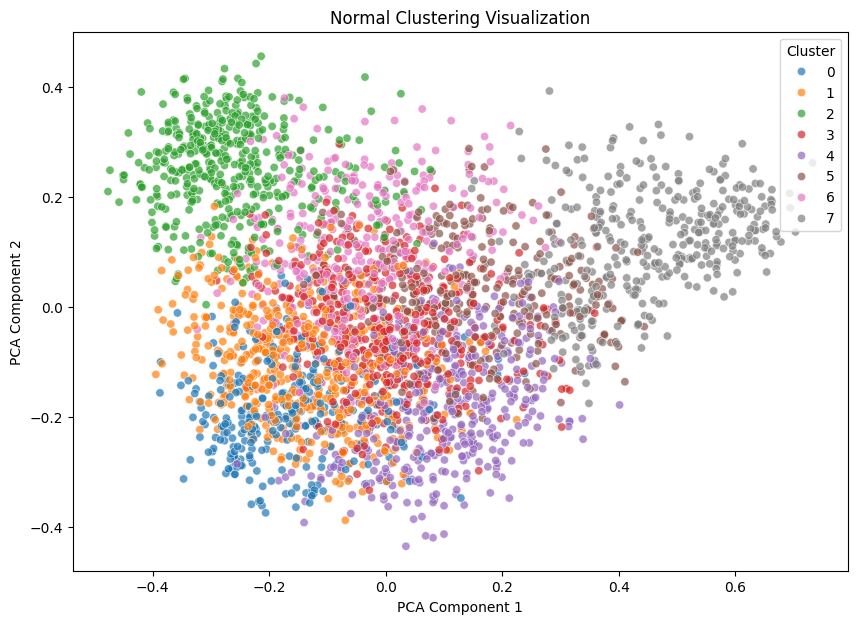

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_reduced)  # Use the reduced data from your pipeline

# Create a scatter plot with cluster labels
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=cluster_labels,  # Use cluster labels from KMeans
    palette='tab10',
    legend='full',
    alpha = 0.7
)

# Add labels and title
plt.title("Normal Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="upper right")
plt.show()
##################################################

classifying which clusters contain what infomration. Notice disaster and sports are separated from financials. And that there is a cluster with mainly science and tech.

In [ ]:
#separate the curated dataframe into n parts based on cluter labels
df_clustered = [dfcurated[dfcurated['labels'] == i] for i in range(num_clustersK)]

#print out the max three categories of each dataframe
for df in df_clustered:
    print(df['news_category'].value_counts().nlargest(3))

news_category
economy, business, and finance    181
science and technology             44
politics                           30
Name: count, dtype: int64
news_category
economy, business, and finance    240
science and technology             96
politics                           92
Name: count, dtype: int64
news_category
economy, business, and finance    402
politics                           22
science and technology             13
Name: count, dtype: int64
news_category
economy, business, and finance    225
science and technology             74
politics                           69
Name: count, dtype: int64
news_category
science and technology                    203
economy, business, and finance             62
arts, culture, entertainment and media     47
Name: count, dtype: int64
news_category
economy, business, and finance    100
politics                           90
science and technology             40
Name: count, dtype: int64
news_category
economy, business, and finance    296


In [ ]:
#adds label 1 to dfgood
dfgood['label'] = 1
dfgood.head()

,title,label
0,Hyundai Motor and Suprema sign MoU to develop ...,1
1,Wumart takes inspiration from Pangdonglai to t...,1
2,"Asbury Automotive Group, Inc. (NYSE:ABG) Share...",1
3,S&PGRBulletin: Allianz To Invest In Run-Off Pl...,1
4,'Perfect Advert' - When Ex-Boss Bernie Ecclest...,1


In [ ]:
#adds label 0 to dfbad
dfbad['label'] = 0
dfbad.head()

,title,label
0,Insider: AD had instant connection to DeVries....,0
1,Kentucky Sen. Rand Paul wants to confront Pres...,0
2,Netflix 'Love on the Spectrum' season 3 cast: ...,0
3,Who will advance to the Final Four? More than ...,0
4,Why UConn coach Geno Auriemma believes the Big...,0


In [ ]:
both = pd.concat([dfgood,dfbad])
both.head()

,title,label
0,Hyundai Motor and Suprema sign MoU to develop ...,1
1,Wumart takes inspiration from Pangdonglai to t...,1
2,"Asbury Automotive Group, Inc. (NYSE:ABG) Share...",1
3,S&PGRBulletin: Allianz To Invest In Run-Off Pl...,1
4,'Perfect Advert' - When Ex-Boss Bernie Ecclest...,1


In [ ]:
texts_cleanG = both['title'].map(preprocess).tolist()
model = SentenceTransformer('FinLang/finance-embeddings-investopedia')

embeddingsG = model.encode(
    texts_cleanG,
    show_progress_bar=True,
    convert_to_numpy=True
)

Batches:   0%|          | 0/144 [00:00<?, ?it/s]

In [ ]:
X_reduced = lsa.fit_transform(embeddingsG)#(X_tfidf)
# Check explained variance
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance: {explained_variance:.2f}")

Explained variance: 0.90


In [ ]:
num_clustersK = 2

# Use NLTK KMeansClusterer
kmeans = KMeansClusterer(
    num_clustersK,
    distance=cosine_distance,
    repeats = 25,
    avoid_empty_clusters=True
)

In [ ]:
# Train the KMeans model
mixed_cluster_labels = kmeans.cluster(X_reduced, assign_clusters=True)

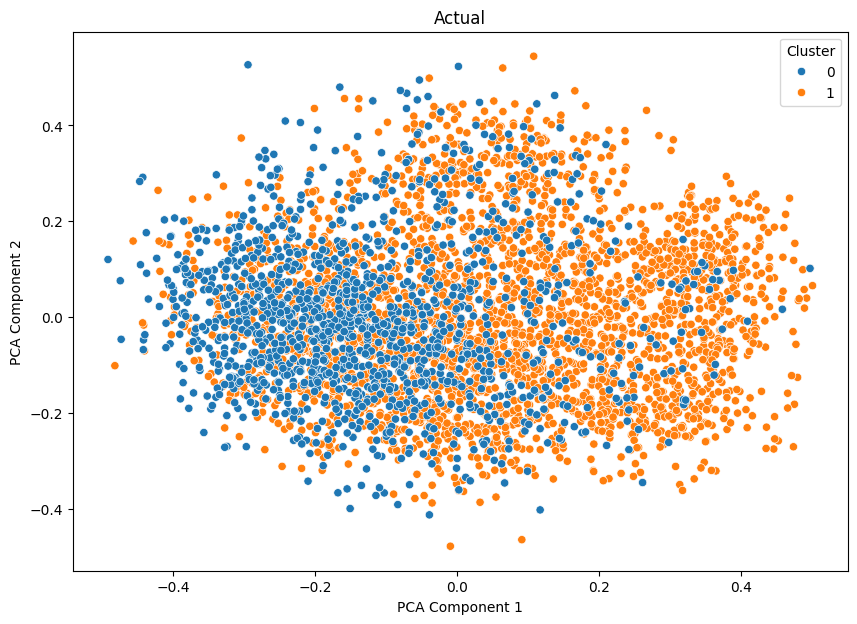

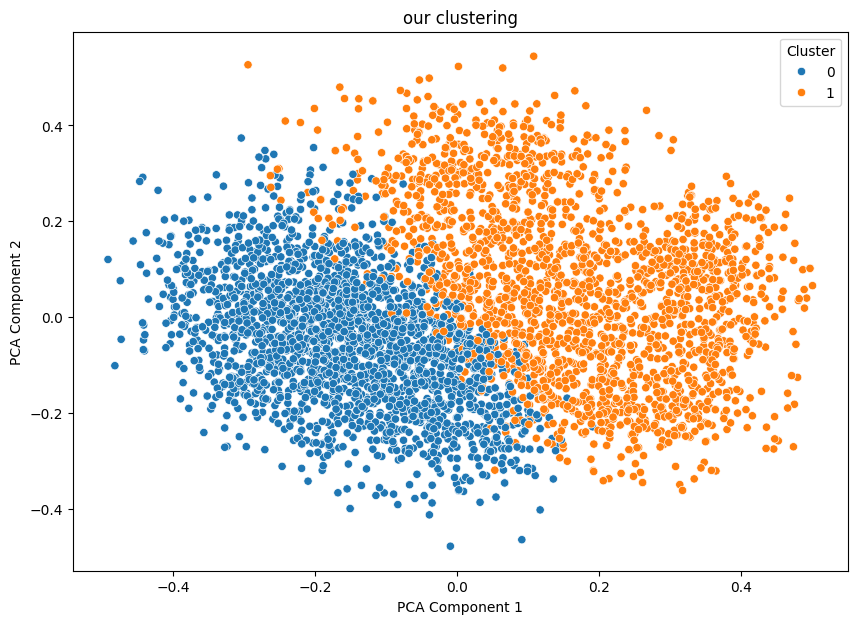

In [ ]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_reduced)  # Use the reduced data from your pipeline
# Create a scatter plot with cluster labels
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
#get data frame both's label colum to hue
    hue=both['label'],  # Use cluster labels from KMeans
    #mixed_cluster_labels,  # Use cluster labels from KMeans
    palette='tab10',
    legend='full'
)

# Add labels and title
plt.title("Actual")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="upper right")
plt.show()
##################################
# Create a scatter plot with cluster labels
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
#get data frame both's label colum to hue
    hue=mixed_cluster_labels,  # Use cluster labels from KMeans
    #mixed_cluster_labels,  # Use cluster labels from KMeans
    palette='tab10',
    legend='full'
)

# Add labels and title
plt.title("our clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="upper right")
plt.show()

# Submit to Kaggle


In [ ]:
import pandas as pd

summit_df = pd.DataFrame(pd.Series(0,index=dfcurated.index),columns=['Cluster'])
summit_df.index.name = 'Index'

#takes cluster labels and assigns it to the dataframe

summit_df['Cluster'] = cluster_labels
summit_df.to_csv('news_baseline.csv')
summit_df

,Cluster
Index,
0,2
1,0
2,6
3,0
4,2
...,...
3226,2
3227,4
3228,0


In [ ]:
#gets accurcy of the both clustering
from sklearn.metrics import accuracy_score
print(accuracy_score(both['label'], mixed_cluster_labels))
#swap labels in case
inverse = 1 - both['label']
print(accuracy_score(inverse, mixed_cluster_labels))


0.6241566920565832
0.37584330794341675


In [ ]:
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics.pairwise import cosine_distances

def compute_manual_auc(embeddings, labels, cluster_center, distance_metric='cosine', num_thresholds=100):
    # Step 1: Compute distance of each embedding to the positive cluster center
    if distance_metric == 'cosine':
        distances = cosine_distances(embeddings, cluster_center.reshape(1, -1)).flatten()
    elif distance_metric == 'euclidean':
        distances = np.linalg.norm(embeddings - cluster_center, axis=1)
    else:
        raise ValueError("Unsupported distance metric. Use 'cosine' or 'euclidean'.")

    # Step 2: Sweep thresholds and compute TPR and FPR at each point
    thresholds = np.linspace(distances.min(), distances.max(), num_thresholds)
    tpr_list = []
    fpr_list = []

    for threshold in thresholds:
        # Predict 1 if within threshold (i.e., closer = more likely relevant)
        preds = (distances <= threshold).astype(int)

        TP = np.sum((preds == 1) & (labels == 1))
        FP = np.sum((preds == 1) & (labels == 0))
        FN = np.sum((preds == 0) & (labels == 1))
        TN = np.sum((preds == 0) & (labels == 0))

        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    # Step 3: Compute AUC
    auc_score = auc(fpr_list, tpr_list)
    return auc_score, fpr_list, tpr_list


Poor ROC curve indicates that our clustering couldn't really separate the market moving from the non market moving with headlines alone

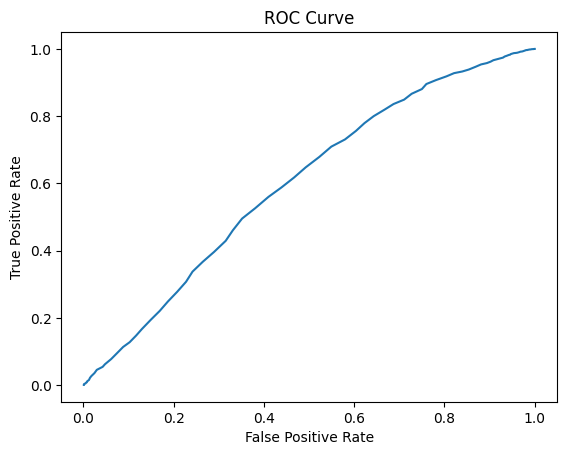

0.6001534813786722


In [ ]:
x = compute_manual_auc(X_reduced, both['label'], kmeans.means()[0])
#plot ROC
import matplotlib.pyplot as plt
plt.plot(x[1], x[2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print(x[0])